# Import Libraries

In [1]:
# stat
import pandas as pd
import numpy as np
import itertools
import statsmodels.api as sm

# data 
import datetime
import json 

# modeling
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input, Concatenate, TimeDistributed, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU

# visualize
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# etc
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


# Load Data (09/08)

In [2]:
from features_yj import Features
train = Features().run_all()

In [3]:
train.sort_values(['방송일시', '상품코드'], ascending=[True, True], inplace=True)

In [4]:
tmp_train = train[['방송일시','취급액','상품군','판매단가','exposed','months','days','freq','temp_diff_s',
                   'spring', 'summer', 'fall', 'winter', 'small_click_r',
                   'mid_click_r', 'big_click_r']]

In [5]:
one_hot = pd.get_dummies(tmp_train['상품군'])
tmp_train.drop('상품군', axis = 1, inplace = True)
tmp_train = tmp_train.join(one_hot)

In [6]:
train_x = tmp_train.iloc[:23813,:]
test_x = tmp_train.iloc[23813:,:]

In [7]:
X_train = train_x.drop(columns = '취급액')
X_test = test_x.drop(columns = '취급액')
y_train = train_x.iloc[:,1]
y_test = test_x.iloc[:,1]

### Dickey-Fuller test

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure. <br />
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure

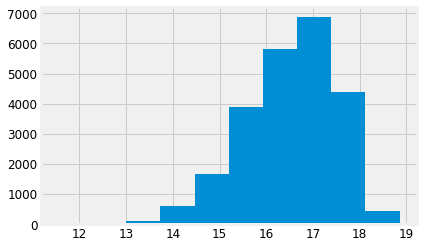

In [8]:
X = y_train.values
X = np.log(X)
plt.hist(X)
plt.show()

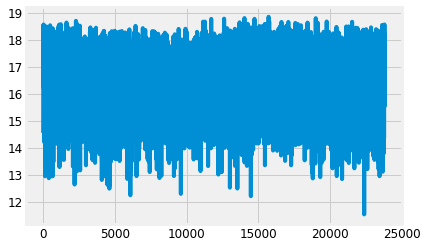

In [9]:
plt.plot(X)
plt.show()

In [10]:
from statsmodels.tsa.stattools import adfuller
X = y_train.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -24.646104
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


#### Apply to hours_inweek

In [11]:
hours_inweek_sales = train.groupby(['ymd']).sum()['취급액']

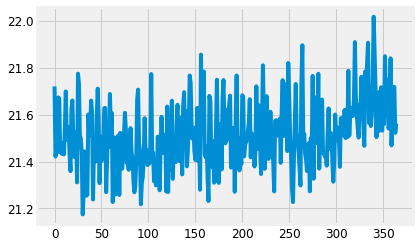

In [12]:
X = hours_inweek_sales.values
X = X[:-1]
X = np.log(X)
plt.plot(X)
plt.show()

In [13]:
result2 = adfuller(hours_inweek_sales)
print('ADF Statistic: %f' % result2[0])
print('p-value: %f' % result2[1])
print('Critical Values:')
for key, value in result2[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.314756
p-value: 0.167253
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571


p-val > 0.05, thus we can conclude that there exists time-dependent variable

## SARIMA

In [14]:
daily_sales = pd.DataFrame(hours_inweek_sales)
daily_sales.index = pd.to_datetime(daily_sales.index, format= "%Y-%m-%d")
daily_sales = daily_sales.iloc[:-1] #drop 2020-01-01

In [15]:
daily_sales.rename(columns = {'취급액' : 'sales'}, inplace = True)

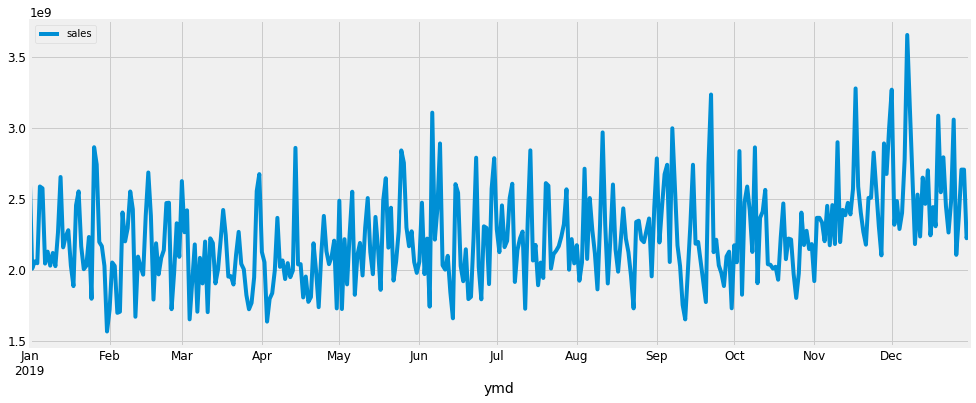

In [16]:
daily_sales.plot(figsize=(15, 6))
plt.show()

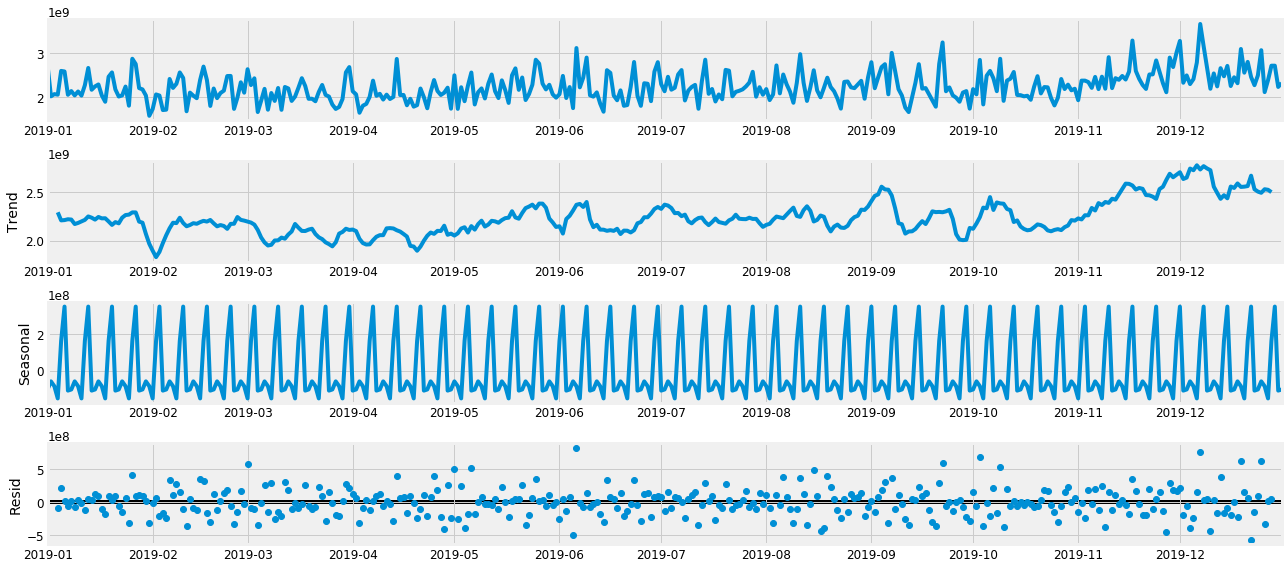

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(daily_sales, model='additive')
fig = decomposition.plot()
plt.show()

In [20]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


이거 p,d,q 조절행야

In [21]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(daily_sales,
                    order=param,
                    seasonal_order=param_seasonal,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:16715.552388297976
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:15940.65674301276
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:15030.326440392964
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:14405.946057538684
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:15071.681003082074
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:14970.501704938442
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:14457.15277719277
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:14386.89845858935
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:16430.074402580183
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:15830.404330409614
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:14976.745905235259
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:14351.00400521206
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:15872.923367523914
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:15782.242425871202
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:14455.495056801425
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:14340.428186271749
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:15389.643219478181
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:14881.778840944

In [22]:
mod = sm.tsa.statespace.SARIMAX(daily_sales,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1671      0.302      0.554      0.580      -0.424       0.758
ma.L1          0.1444      0.285      0.508      0.612      -0.413       0.702
ar.S.L12      -0.3518      0.123     -2.849      0.004      -0.594      -0.110
ma.S.L12      -0.3587      0.091     -3.927      0.000      -0.538      -0.180
sigma2      1.941e+17   1.16e-19   1.67e+36      0.000    1.94e+17    1.94e+17


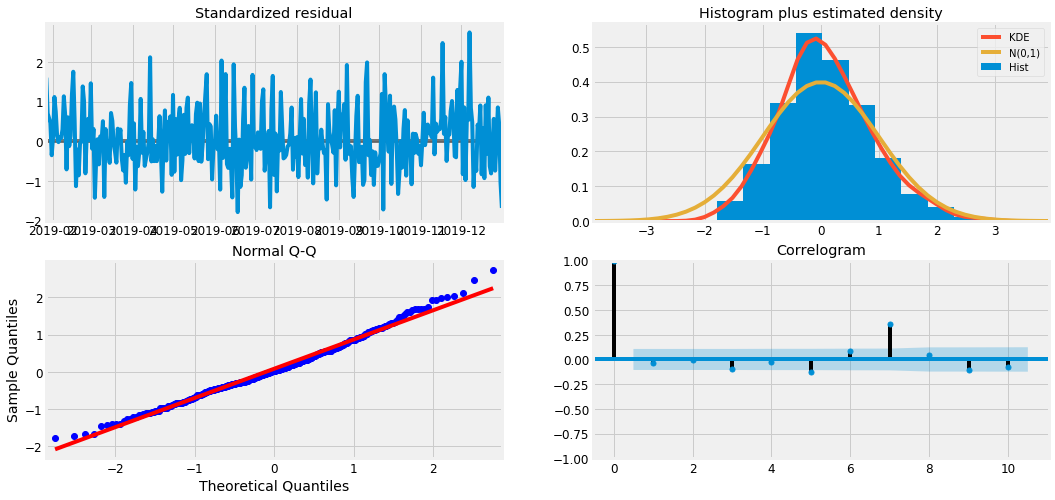

In [23]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

### validate

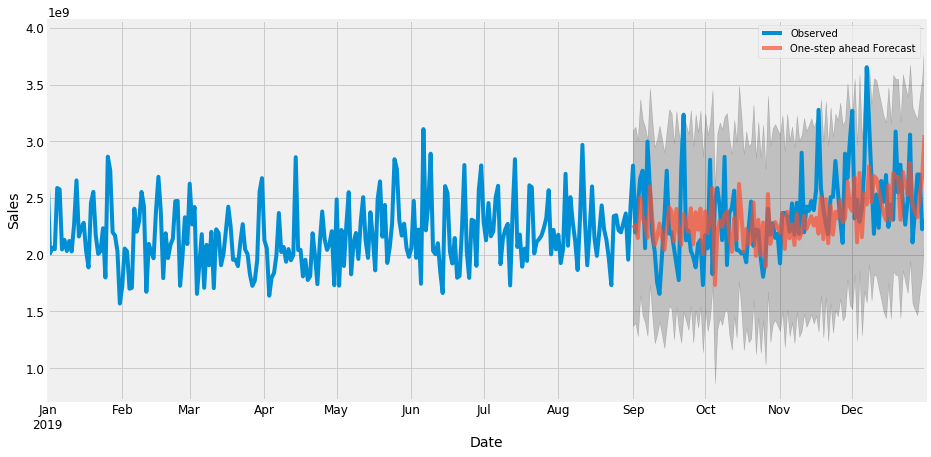

In [24]:
pred = results.get_prediction(start=pd.to_datetime('2019-09-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = daily_sales['2019-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend(('Observed','One-step ahead Forecast'))
plt.show()

In [31]:
y_forecasted = pred.predicted_mean
y_truth = daily_sales['2019-09-01':].sales
# y_truth.index = pd.to_datetime(y_truth.index)
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.4022661966817837e+17


In [33]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 374468449.5


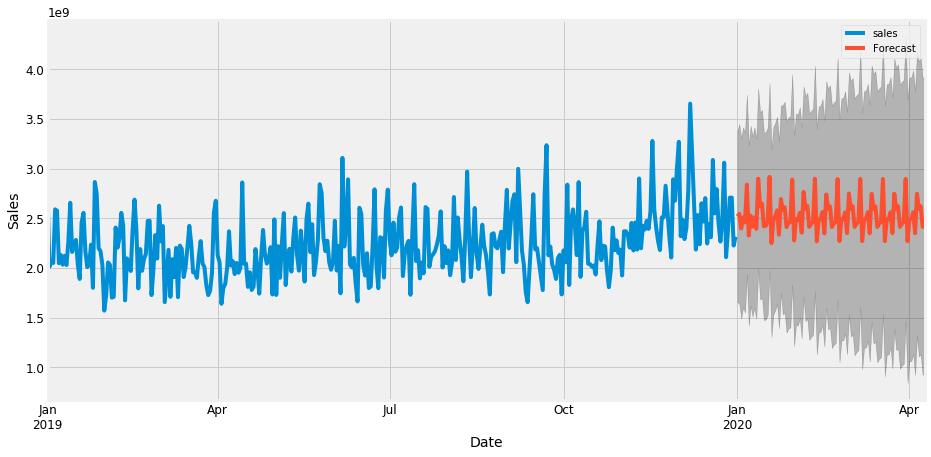

In [37]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = daily_sales.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [43]:
daily_sales

,sales
ymd,
2019-01-01,2.712779e+09
2019-01-02,2.011023e+09
2019-01-03,2.062043e+09
2019-01-04,2.049394e+09
2019-01-05,2.588390e+09
...,...
2019-12-27,2.378887e+09
2019-12-28,2.706958e+09
2019-12-29,2.706806e+09


## prophet

In [49]:
daily_sales.reset_index(inplace= True)
daily_sales.rename(columns={'ymd': 'ds', 'sales': 'y'}, inplace = True)

<Figure size 1296x432 with 0 Axes>

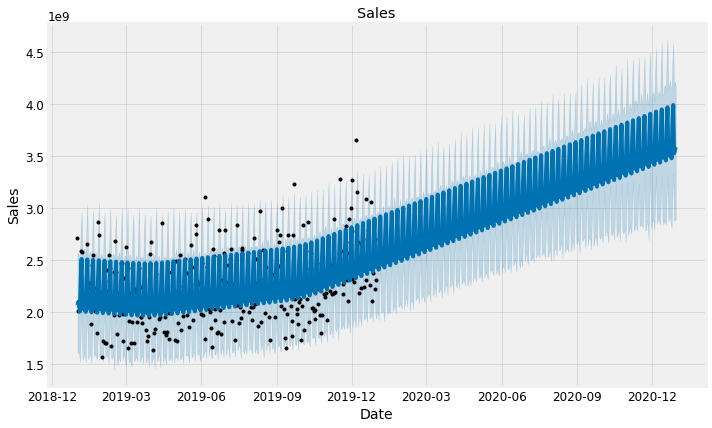

In [51]:
from fbprophet import Prophet

daily_sales = daily_sales.rename(columns={'ymd': 'ds', 'sales': 'y'})
daily_sales_model = Prophet(interval_width=0.95)
daily_sales_model.fit(daily_sales)
sales_forecast = daily_sales_model.make_future_dataframe(periods=365)
sales_forecast = daily_sales_model.predict(sales_forecast)

plt.figure(figsize=(18, 6))
daily_sales_model.plot(sales_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Sales');